# SQUANCH Demonstration
## Attenuated superdense coding down a fiber optic cable

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

%matplotlib inline

from squanch import qstream, gates

In [8]:
fiberOpticAttenuation = -0.16  # dB/km, from Yin, et al, Satellite-based entanglement
cableLength = 1  # km, let's just call it this for now 
# Total attenuation along the fiber, equal to probability of receiving a photon
decibelLoss = cableLength * fiberOpticAttenuation
cableAttenuation = 10 ** (decibelLoss / 10)


def attenuatedSuperdenseTransmission(bit1, bit2, qStream, streamIndex):
    # Alice prepares a two-qubit system
    aliceIndex = 0
    bobIndex = 1

    AB = qStream.system(streamIndex)

    # Prepare the bell pair
    AB.apply(gates.H, aliceIndex)
    AB.apply(gates.CNOT)

    # Alice sends the first qubit to Bob - if it is attenuated, return 0,0
    if np.random.rand() > cableAttenuation:
        return 0, 0

    # Alice encodes her bits
    if bit2 == 1:
        AB.apply(gates.X, aliceIndex)
    if bit1 == 1:
        AB.apply(gates.Z, aliceIndex)

    # Alice sends her qubit to bob and then he decodes the bits
    if np.random.rand() > cableAttenuation:
        return 0, 0
    AB.apply(gates.CNOT)
    AB.apply(gates.H, aliceIndex)

    # Measure the results
    outputBit1 = AB.measureQubit(aliceIndex)
    outputBit2 = AB.measureQubit(bobIndex)

    return outputBit1, outputBit2

def attenuatedIntTransmission(value, qStream, streamIndex):
    '''Transmit an 8-bit unsigned integer value including attenuation effects'''
    bits = np.unpackbits(np.array([value], dtype=np.uint8))
    receivedBits = np.zeros(8, dtype=np.uint8)
    for i in range(4):
        b1, b2 = attenuatedSuperdenseTransmission(bits[2 * i], bits[2 * i + 1], qStream, streamIndex)
        receivedBits[2 * i] = b1
        receivedBits[2 * i + 1] = b2
        streamIndex += 1
    return np.packbits(receivedBits)[0]

def attenuatedArrayTransmission(array):
    bitsToSend = array.size * 8 * np.dtype(np.uint8).itemsize
    numQuantumSystems = bitsToSend / 2
    qs = qstream.QStream(2, numQuantumSystems)
    receivedArray = np.zeros(array.shape, dtype=np.uint8)
    iterator = np.nditer(array, flags=['multi_index'])

    streamCounter = 0  # TODO: incorporate this into QStream class
    while not iterator.finished:
        receivedElement = attenuatedIntTransmission(iterator[0], qs, streamCounter)
        streamCounter += 4
        receivedArray[iterator.multi_index] = receivedElement
        iterator.iternext()
    return receivedArray

Original image:


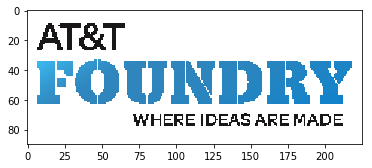

In [6]:
# Let's try transmitting the following image: 
imgData = mp.image.imread("img/foundryLogo.bmp") 
print "Original image:"
plt.imshow(imgData)

Reconstructed transmitted image accounting for attenuation effects:


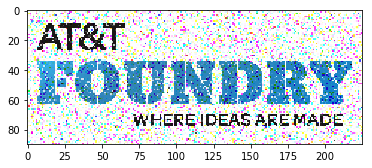

In [9]:
# Transmit the image with the attenuated superdense protocol
receivedArray = attenuatedArrayTransmission(imgData)
print "Reconstructed transmitted image accounting for attenuation effects:"
plt.imshow(receivedArray)